Pairs Trading in Crytpo, Event Driven Backtesting and Evaluation

In [1]:
import warnings
warnings.filterwarnings('ignore')

1. Data processing & EDA

In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import datetime
import os
import shutil
from decimal import Decimal
import fsspec
import pandas as pd

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/tencars/392-crypto-currency-pairs-at-minute-resolution")

Skipping, found downloaded files in "./392-crypto-currency-pairs-at-minute-resolution" (use force=True to force download)


In [5]:
DATA_DIR = "./392-crypto-currency-pairs-at-minute-resolution"
fs = fsspec.filesystem('file')
raw_files = fs.glob(f"{DATA_DIR}/*.csv")
assert raw_files, f"Unable to find any histdata files in directory {DATA_DIR}"

I found that CSV file with "_usd.csv" is the relatively latest spot price data, so I will use spot price data for correlation calculation and long/short portfolio calculation

In [6]:
spot = [link for link in raw_files if link.endswith('_usd.csv') ] # for correlation calculation

I see the time interval in these files concentrate from 2023-06-03 12:00:00 to 2023-06-11 12:00:00, so I will use interval 2023-06-03 12:00:00 => 2023-06-09 12:00:00 of the data for correlation calculation and interval 2023-06-09 12:00:00 => 2023-06-11 12:00:00 for backtesting

In [7]:
#use multi threading to read all the csv files with file path array spot to pandas dataframe, with index as datetime, symbol as column name and close price as value, and then concatenate all the dataframes into one dataframe

import os
import pandas as pd
from tqdm import tqdm
from typing import List
import dask.dataframe as dd
import multiprocessing

def read_csv_to_df(file_path: str) -> pd.DataFrame:
  df = pd.read_csv(file_path, index_col = 'time')
  df = df[['close']]
  df.columns = [file_path.split('/')[-1].replace(".csv","")]
  df.index = pd.to_datetime(df.index, unit='ms')

  # assume df is a dataframe with a datetime index
  start_time = '2023-06-03 12:00:00'
  end_time = '2023-06-11 12:00:00'
  # create a new datetime index at 5-minute intervals
  new_index = pd.date_range(start=start_time, end=end_time, freq='5T')
  # resample the dataframe to the new index
  df_resampled = df.resample('5T').last().reindex(new_index)
  # fill missing values with the last observed value
  df_resampled.fillna(method='ffill', inplace=True)

  return df_resampled

def read_csvs_to_df(file_paths: List[str]) -> pd.DataFrame:
    with multiprocessing.Pool() as pool:
        dfs = list(tqdm(pool.map(read_csv_to_df, file_paths), total=len(file_paths)))
    return dfs

temp = read_csvs_to_df(spot)

spot_df = dd.concat(temp, axis=1).compute()


100%|██████████| 67/67 [00:00<00:00, 446060.90it/s]


In [8]:
# count the number of missing values in each column
na_counts = spot_df.isna().sum()

# drop columns with more than 0 NaN value
spot_df = spot_df.drop(columns=na_counts[na_counts >= 1].index)

In [9]:
start_time = '2023-06-03 12:00:00'
end_time = '2023-06-09 12:00:00'

# Convert the start_time and end_time strings to datetime objects
start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

# Use boolean indexing to slice the DataFrame
spot_df_corr_test = spot_df[(spot_df.index >= start_time) & (spot_df.index <= end_time)]

Cointegration test is chosen for finding the correlated pairs for this pairs trading strategy, and I choose 0.5% as minimum P-value for the cointegration test

In [10]:
import numpy as np
from statsmodels.tsa.stattools import coint

min_pvalue = 0.005

def find_cointegrated_pairs(data,min_pvalue):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            #if pvalue is smaller than minimum P-value, reject null hypothesis
            #and conclude the pair is correlated
            if pvalue < min_pvalue:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [11]:
scores, pvalues, pairs = find_cointegrated_pairs(spot_df_corr_test,min_pvalue)
print("Below pairs of crypto are chosen for pairs trading strategy")
print(pairs)

Below pairs of crypto are chosen for pairs trading strategy
[('chsb_usd', 'ethw_usd'), ('chsb_usd', 'shib_usd'), ('chsb_usd', 'spell_usd'), ('chsb_usd', 'sushi_usd'), ('mxnt_usd', 'polc_usd'), ('mxnt_usd', 'shib_usd'), ('mxnt_usd', 'spell_usd'), ('mxnt_usd', 'sushi_usd')]


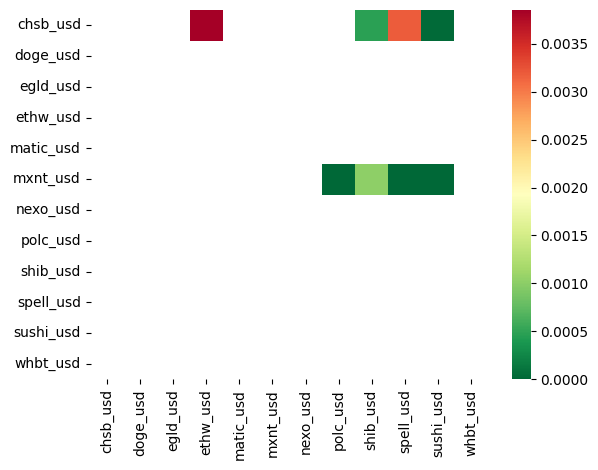

In [12]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
seaborn.heatmap(
    pvalues,
    xticklabels=spot_df.columns,
    yticklabels=spot_df.columns,
    cmap='RdYlGn_r',
    mask = (pvalues >min_pvalue))
plt.show()

I verify the correlation by calculating the actual correlations between all coins we got from the cointegration test.

In [13]:
all_coins = [a for (a,b) in pairs] + [b for (a,b) in pairs]
unique_coins = list(set(all_coins))
selected_spot_df_corr_test = spot_df_corr_test[unique_coins]
pair_correlations = selected_spot_df_corr_test.corr()

<Axes: >

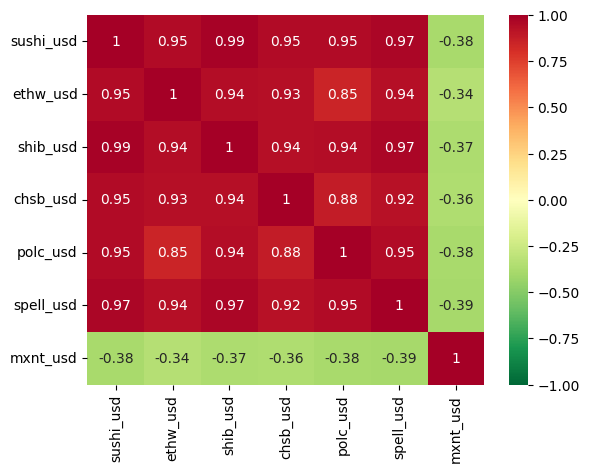

In [14]:
#use heatmap to show the correlation between each pair of crypto
seaborn.heatmap(
    pair_correlations,
    xticklabels=pair_correlations.columns,
    yticklabels=pair_correlations.columns,
    cmap='RdYlGn_r',
    annot=True,
    vmin=-1,
    vmax=1)

It is shown in the heatmap that mxnt is relatively not correlated to other coins, so I will remove this coin from our strategy.

In [15]:
final_pairs = [pair for pair in pairs if not ("mxnt_usd" in pair)]
final_pairs

[('chsb_usd', 'ethw_usd'),
 ('chsb_usd', 'shib_usd'),
 ('chsb_usd', 'spell_usd'),
 ('chsb_usd', 'sushi_usd')]

2. Hypothesis + Rationale

My strategy is to do pair trading on the above 4 pairs with z-score of OLS spread as an indicator, I come up with below strategy detail based on historical data with same time horizon as cointegration test.

Rolling normalized spread of other/chsb will be similar in range (1.5+1.5=3) as below graph, but are skewed to downside because in general market drops faster than rally, so the criteria for pairs trading in this project will be:


*   if 10 minutes' rolling normalized spread > +1, short other/chsb pair, i.e. short sell other and buy chsb, both using 50% of the total capital
*   if 10 minutes' rolling normalized spread < -2, long other/chsb pair, i.e. buy other and short sell chsb, both using 50% of the total capital
*   if 10 minutes' rolling normalized spread is between -1.2 and +1.2, hold the current portfolio

In [16]:
import statsmodels.api as sm

def zscore(series):
    return (series - series.mean()) / np.std(series)

def spread_calculation(selected_spot_df_corr_test,final_pairs):
    all_spreads = pd.DataFrame()
    for (chsb,other) in final_pairs:
        S1 = selected_spot_df_corr_test[chsb]
        S2 = selected_spot_df_corr_test[other]
        X = sm.add_constant(S1)
        result = (sm.OLS(S2,X)).fit()
        b = result.params[chsb]
        c = result.params['const']
        spread = S2 - (b*S1 + c)
        all_spreads[other] = zscore(spread)
    #calculate average spread as the spread of the portfolio
    all_spreads['avg_spread'] = all_spreads.mean(axis=1)
    return all_spreads

all_spreads = spread_calculation(spot_df_corr_test,final_pairs)

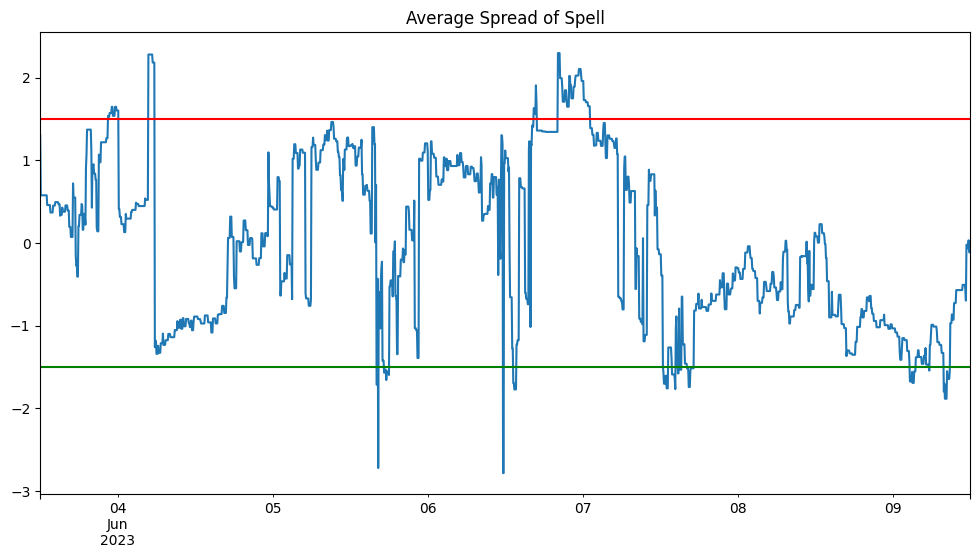

In [17]:
#plot the avg_spread of the portfolio
all_spreads['spell_usd'].plot(figsize=(12,6))
plt.axhline(1.5, color='red')
plt.axhline(-1.5, color='green')
plt.title("Average Spread of Spell")
plt.show()

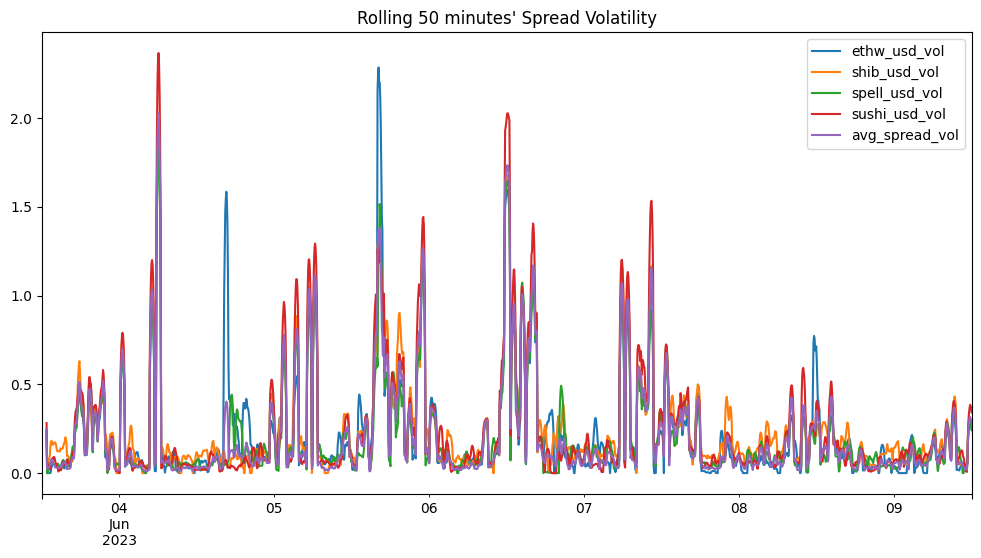

ethw_usd_vol 0.2312636117745953
shib_usd_vol 0.2537156677823432
spell_usd_vol 0.21277045528324623
sushi_usd_vol 0.2495770948895781
avg_spread_vol 0.2157071394320413


In [18]:
#calculate volatility of all_spreads, for each column individually in rolling window of 10
for column in all_spreads.columns:
    all_spreads[column+'_vol'] = all_spreads[column].rolling(10).std()

#plot the volatility of the portfolio
for column in all_spreads.columns:
    if '_vol' in column:
        all_spreads[column].plot(figsize=(12,6),label=column)
plt.legend()
plt.title("Rolling 50 minutes' Spread Volatility")
plt.show()

#print average volatility of the portfolio
for column in all_spreads.columns:
    if '_vol' in column:
        print(column,all_spreads[column].mean())


As ethw, shib, spell and sushi are also highly correlated to each other, to reduce transaction cost, our final trading pair is spell/chsb because the spread has lowest rolling average volatility, which is good for pairs trading.

3. Event Driven Backtesting using backtrader library

In [19]:
!pip install backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import backtrader as bt

Make data0 = spell, and data1 = chsb

In [21]:
trading_pair = ['spell_usd', 'chsb_usd']

Below is the back-tester with documentation in the coding, using the criteria for pairs trading mentioned above

In [22]:
class PairTradingStrategy(bt.Strategy):
    params = dict(
        period=2,
        stake=10,
        qty1=0,
        qty2=0,
        previous_price_1=0,
        previous_price_2=0,
        printout=False,
        upper=1,
        lower=-2,
        status=0,
        portfolio_value= pd.DataFrame([['2023-06-09 12:00:00',10000]], columns=['time','Portfolio Value']),
        trade = []
    )

    def log(self, txt, dt=None):
        if self.p.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = None

    def __init__(self):
        # To control operation entries
        self.orderid = None
        self.qty1 = self.p.qty1
        self.qty2 = self.p.qty2
        self.upper_limit = self.p.upper
        self.lower_limit = self.p.lower
        self.status = self.p.status
        self.portfolio_value = self.p.portfolio_value
        self.previous_price_1= self.p.previous_price_1
        self.previous_price_2= self.p.previous_price_2
        self.trade= self.p.trade

        # Signals performed with PD.OLS : commented because the below function is not working due to version problem
        # changed to below calculate_zscore function
        #self.transform = btind.OLS_TransformationN(self.data0, self.data1,period=self.p.period)
        #self.zscore = self.transform.zscore
        self.zscore = [0]


    def calculate_zscore(self):
        dt = self.data0.datetime.datetime()
        current_time = dt.strftime('%Y-%m-%d %H:%M:%S')
        data0 = pd.read_csv("data0.csv")
        data1 = pd.read_csv("data1.csv")
        _data0 = None
        _data1 = None
        latest_spread = []
        if len(data1['close'][:current_time]) >20:
            _data1 = data1['close'][:current_time][-21:]
            _data0 = data0['close'][:current_time][-21:]
            X = sm.add_constant(_data1)
            result = (sm.OLS(_data0,X)).fit()
            b = 0
            c = 0
            if len(result.params)>1:
                b = result.params['close']
                c = result.params['const']
            else:
                b = result.params['close']
            spread = _data0 - (b*_data1 + c)
            final_spread = zscore(spread)
            latest_spread = [final_spread.iloc[-1]]
        else:
            latest_spread = [0]
        return latest_spread

    def next(self):

        if self.orderid:
            return  # if an order is active, no new orders are allowed

        # Simply debug message
        if self.p.printout:
            print('Self  len:', len(self))
            print('Data0 len:', len(self.data0))
            print('Data1 len:', len(self.data1))
            print('Data0 len == Data1 len:',len(self.data0) == len(self.data1))
            print('Data0 dt:', self.data0.datetime.datetime())
            print('Data1 dt:', self.data1.datetime.datetime())
            print('status is', self.status)
            print('zscore is', self.zscore[0])
            print('spell_usd is', self.data0.close[0])
            print('chsb_usd is', self.data1.close[0])
            print('portfolio value is', self.portfolio_value)

        self.zscore = self.calculate_zscore()
        dt = self.data0.datetime.datetime()
        current_time = dt.strftime('%Y-%m-%d %H:%M:%S')


        # Step 2: Check conditions for SHORT & place the order
        # Checking the condition for SHORT
        if (self.zscore[0] > self.upper_limit) and (self.status != 1):

            # Calculating the number of shares for each coin
            value = 0.5 * self.portfolio_value[-1:]['Portfolio Value']  # Divide the cash equally
            x = int(value / (self.data0.close[0]))  # Find the number of shares for spell_usd
            y = int(value / (self.data1.close[0]))  # Find the number of shares for chsb_usd
            # Placing the order: commented because the below function is not working due to version problem
            #self.sell(data=self.data0.close, size=(x + self.qty1)) # Place an order for selling x + qty1 shares spell_usd
            #self.buy(data=self.data1.close, size=(y + self.qty2)) # Place an order for buying y + qty2 shares chsb_usd
            data0_pnl = 0
            data1_pnl = 0
            if self.previous_price_1>0:
                data0_pnl = (self.data0.close[0] - self.previous_price_1) * self.qty1
            if self.previous_price_2>0:
                data1_pnl = (self.previous_price_2 - self.data1.close[0]) * self.qty2

            # Insert Dict to the dataframe using DataFrame.append()
            new_row = {'time':current_time, 'Portfolio Value':self.portfolio_value.iloc[-1:]['Portfolio Value'] + data0_pnl + data1_pnl}
            self.portfolio_value = self.portfolio_value.append(new_row, ignore_index=True)

            if self.p.printout:
                print('========================='+current_time +'=========================')
                print('=========================z-score: '+str(self.zscore[0]) +'=========================')
                print("Sell Spell @" + str(self.data0.close[0]) + " with pnl " + str(data0_pnl))
                print("Buy Chsb @" + str(self.data1.close[0]) + " with pnl " + str(data1_pnl))
                print('==================================================')
                print('Portfolio Value : %.2f' % self.portfolio_value.iloc[-1]['Portfolio Value'])

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Coin1 is x shares
            self.qty2 = y  # The new open position quantity for Coin2 is y shares
            self.previous_price_1 = self.data0.close[0]
            self.previous_price_2 = self.data1.close[0]

            self.status = 1  # The current status is "short the spread"

            # Step 3: Check conditions for LONG & place the order
            # Checking the condition for LONG
        elif (self.zscore[0] < self.lower_limit) and (self.status != 2):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value[-1:]['Portfolio Value']  # Divide the cash equally
            x = int(value / (self.data0.close[0]))  # Find the number of shares for spell_usd
            y = int(value / (self.data1.close[0]))  # Find the number of shares for chsb_usd

            # Place the order: commented because the below function is not working due to version problem
            #self.buy(data=self.data0.close, size=(x + self.qty1))  # Place an order for buying x + qty1 shares spell_usd
            #self.sell(data=self.data1.close, size=(y + self.qty2))  # Place an order for selling y + qty2 shares chsb_usd
            data0_pnl = 0
            data1_pnl = 0
            if self.previous_price_1>0:
                data0_pnl = (self.previous_price_1 - self.data0.close[0]) * self.qty1
            if self.previous_price_2>0:
                data1_pnl = (self.data1.close[0] - self.previous_price_2) * self.qty2

            # Insert Dict to the dataframe using DataFrame.append()
            new_row = {'time':current_time, 'Portfolio Value':self.portfolio_value.iloc[-1:]['Portfolio Value'] + data0_pnl + data1_pnl}
            self.portfolio_value = self.portfolio_value.append(new_row, ignore_index=True)
            if self.p.printout:
                print('========================='+current_time +'=========================')
                print('=========================z-score: '+str(self.zscore[0]) +'=========================')
                print("Buy Spell @" + str(self.data0.close[0]) + " with pnl " + str(data0_pnl))
                print("Sell Chsb @" + str(self.data1.close[0]) + " with pnl " + str(data1_pnl))
                print('==================================================')
                print('Portfolio Value : %.2f' % self.portfolio_value.iloc[-1]['Portfolio Value'])

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Coin1 is x shares
            self.qty2 = y  # The new open position quantity for Coin2 is y shares
            self.previous_price_1 = self.data0.close[0]
            self.previous_price_2 = self.data1.close[0]

            self.status = 2  # The current status is "long the spread"


    def stop(self):
        print('==================================================')
        print('Starting Value : %.2f' % self.broker.startingcash)
        print('Ending   Value : %.2f' % self.portfolio_value.iloc[-1]['Portfolio Value'])
        print('==================================================')
        # Plot the result, make x axis sparse
        plt.figure(figsize=(12, 6))
        plt.plot(self.portfolio_value['time'], self.portfolio_value['Portfolio Value'])
        plt.xticks(self.portfolio_value['time'][::3], rotation=45)
        plt.show()



All backtest related arguments are stored in below class.

In [23]:
class all_backtest_args:
    def __init__(self, trading_pair):
        #1st data into the system
        self.data0 = trading_pair[0]
        #2nd data into the system
        self.data1 = trading_pair[1]

    #Starting date in %Y-%m-%d %H:%M:%S format
    fromdate = '2023-06-09 12:00:00'
    #To date in %Y-%m-%d %H:%M:%S format
    todate = '2023-06-11 12:00:00'
    #Starting Cash
    cash = 10000

Full backtesting process with documentation is shown below.

Starting Value : 10000.00
Ending   Value : 9527.91


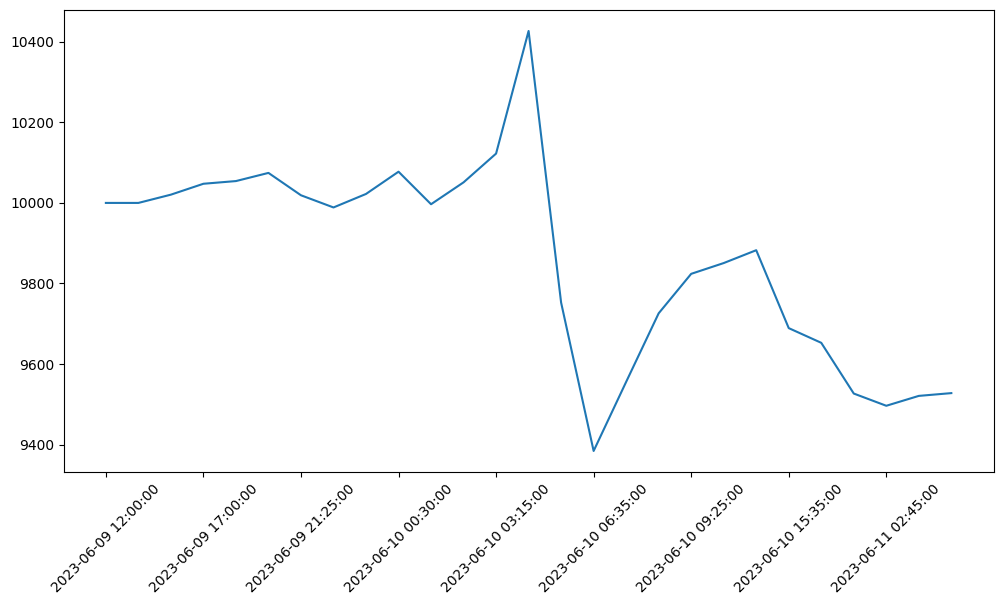

In [24]:
args = all_backtest_args(trading_pair)

# Convert the start_time and end_time strings to datetime objects
start_time = pd.to_datetime(args.fromdate)
end_time = pd.to_datetime(args.todate)

# Use boolean indexing to slice the DataFrame
spot_df_back_test = spot_df[(spot_df.index >= start_time) & (spot_df.index <= end_time)]

# Create a cerebro
cerebro = bt.Cerebro()

# Create the 1st data
_data0 = spot_df_back_test[['spell_usd']]
_data0.columns = ['close']
_data0.to_csv("data0.csv", index_label=False)
data0 = bt.feeds.PandasData(dataname=_data0)


# Add the 1st data to cerebro
cerebro.adddata(data0)

# Create the 2nd data
_data1 = spot_df_back_test[['chsb_usd']]
_data1.columns = ['close']
_data1.to_csv("data1.csv", index_label=False)
data1 = bt.feeds.PandasData(dataname=_data1)

# Add the 2nd data to cerebro
cerebro.adddata(data1)

# Add the strategy
cerebro.addstrategy(PairTradingStrategy)

# Add pyfolio for calculating statistics and plotting backtesting graph
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Add initial cash
cerebro.broker.setcash(args.cash)

# Run the backtesting and analyze the backtesting reuslt
results = cerebro.run()

array([<Axes: >, <Axes: >], dtype=object)

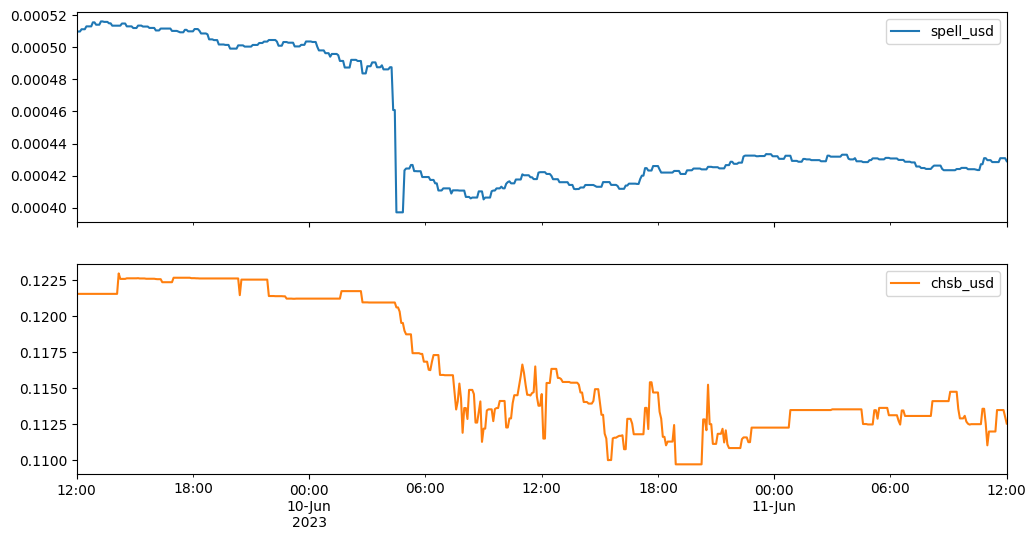

In [25]:
spot_df_back_test[['spell_usd', 'chsb_usd']].plot(subplots=True, figsize=(12, 6))

4. Edge & Bottle Neck of the strategy and future improvements


*    The above graphs show the strategy can effectively capture the temporary correlation breakdown when both coins are within a stable price range
*    However, the above graphs show a sharp drawdown at around 6pm on 10 Jun because Spell breaks out its current price range faster than Chsb does, so the model cannot capture this kind of price range breakout movement
*   Possible future improvements are adding stop loss to avoid having significant drawdown during price range breakout movement, or adding predictor function to classify that it is a price range breakout so the position can be closed immediately after the classification